In [1]:
from dotenv import load_dotenv
import os
from huggingface_hub import login

load_dotenv("../../.env")
huggingface_token = os.environ["HUGGINGFACE_TOKEN"]
login(token=huggingface_token)

/home/rubenbalbastre/Escritorio/Repositorios/LLM/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download Data

In [2]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2026-01-12 10:49:08--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[185.199.108.133]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 1115394 (1,1M) [text/plain]
Guardando como: ‘input.txt.1’

input.txt.1         100%[===================>]   1,06M  5,07MB/s    en 0,2s    

2026-01-12 10:49:09 (5,07 MB/s) - ‘input.txt.1’ guardado [1115394/1115394]



## Tokenize the data

Tokenization is done at character level instead of token level for learning purposes

In [3]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [5]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [6]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)

torch.Size([1115394]) torch.int64


## Dataset Splits: training & validation

In [7]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

## Prepare Data Batches

In [8]:
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

In [9]:
import torch 
torch.manual_seed(1337)

def get_batch(split, block_size=block_size, batch_size=batch_size):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train', block_size=block_size, batch_size=batch_size)
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


## Models

### Bigram Model

We assume the next token (at time t+1) only the depends on the last token (at time t). For this, we use a simple embedding layer which acts as a learnable vector mapping.

#### Definition

In [10]:
import torch
import torch.nn as nn 
from torch.nn import functional as F
torch.manual_seed(1333)


def compute_loss(logits, targets):
    B, T, C = logits.shape
    logits = logits.view(B*T, C)
    targets = targets.view(B*T)
    loss = F.cross_entropy(logits, targets)
    return loss


class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size) # Vocab Size, Channel

    def forward(self, x):
        logits = self.token_embedding_table(x) # (B,T,C)
        return logits

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits = m(xb)
loss = compute_loss(logits, yb)
print(logits.shape)
print(loss)

torch.Size([4, 8, 65])
tensor(4.5951, grad_fn=<NllLossBackward0>)


In [11]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


Jv
&H?JZDB.RNbfuJb.R$
; n
SihyVKJZNnAH:ZNL,C.CBJ;rKrbVP-?dhgUdk3Ea;XKgd$D-WgdoPAaza.PAalt!IPdMcb?Kjw


#### Training

In [12]:
@torch.no_grad()
def estimate_loss(model, eval_iters=200):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits = model(X)
            loss = compute_loss(logits, Y)
            losses[k] = loss.item()
        out[split] = losses.mean().item()
    model.train()
    return out

In [13]:
batch_size = 32
n_steps = 10000

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

losses_record = []
for steps in range(n_steps): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # predict next token
    logits = m(xb)

    # evaluate the loss
    loss = compute_loss(logits, yb)

    if steps % 200 == 0 or steps == n_steps - 1:
        losses = estimate_loss(model=m)
        print(f"step {steps}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        losses['model'] = 'Bigram'
        losses['steps'] = steps
        losses_record.append(losses)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


step 0: train loss 4.6562, val loss 4.6707
step 200: train loss 4.5052, val loss 4.5111
step 400: train loss 4.3843, val loss 4.3798
step 600: train loss 4.2187, val loss 4.2364
step 800: train loss 4.1091, val loss 4.1352
step 1000: train loss 3.9868, val loss 4.0094
step 1200: train loss 3.8835, val loss 3.9107
step 1400: train loss 3.7789, val loss 3.7941
step 1600: train loss 3.6965, val loss 3.7018
step 1800: train loss 3.6478, val loss 3.6180
step 2000: train loss 3.5321, val loss 3.5292
step 2200: train loss 3.4531, val loss 3.4835
step 2400: train loss 3.3905, val loss 3.4060
step 2600: train loss 3.3236, val loss 3.3256
step 2800: train loss 3.2464, val loss 3.2572
step 3000: train loss 3.2220, val loss 3.2110
step 3200: train loss 3.1129, val loss 3.1531
step 3400: train loss 3.1025, val loss 3.1458
step 3600: train loss 3.0679, val loss 3.0912
step 3800: train loss 3.0433, val loss 3.0547
step 4000: train loss 2.9766, val loss 3.0079
step 4200: train loss 2.9616, val loss 2.

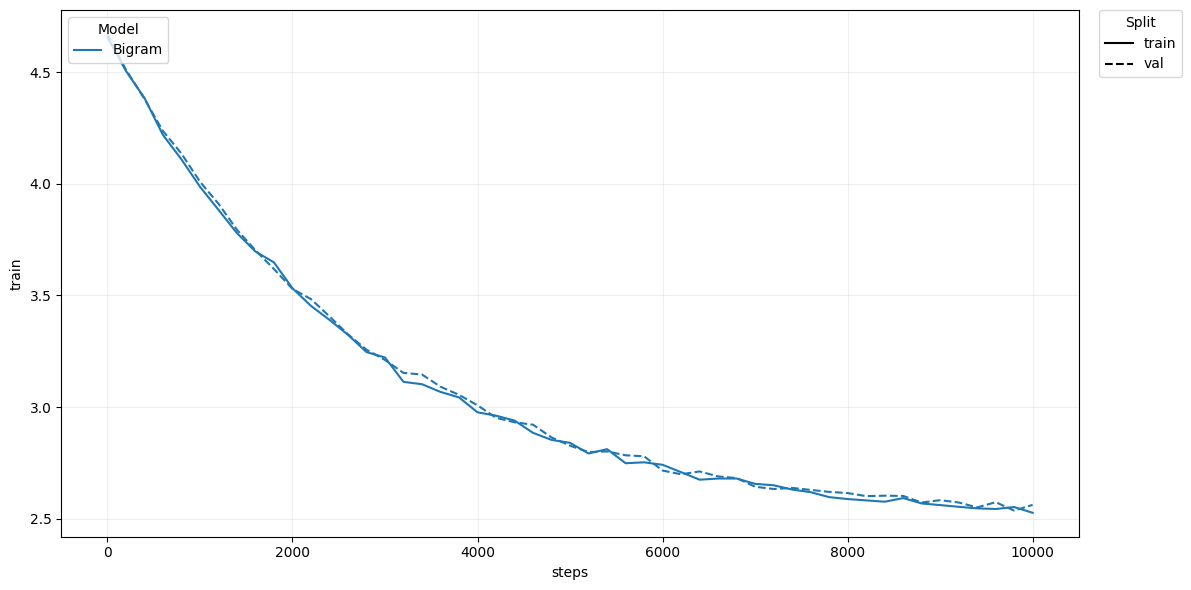

In [14]:
import pandas as pd

losses_df = pd.DataFrame(losses_record)

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

def plot_losses(losses_df):

    fig, ax = plt.subplots(figsize=(12, 6))

    sns.lineplot(data=losses_df, x="steps", y="train", hue="model", ax=ax)
    sns.lineplot(data=losses_df, x="steps", y="val",   hue="model", linestyle="--", ax=ax, legend=False)

    ax.grid(alpha=0.2)

    # Seaborn's model legend (keep it inside)
    legend1 = ax.legend(title="Model", loc="upper left")
    ax.add_artist(legend1)

    # Custom linestyle legend (place it outside)
    style_legend = [
        Line2D([0], [0], color="black", linestyle="-",  label="train"),
        Line2D([0], [0], color="black", linestyle="--", label="val"),
    ]
    ax.legend(
        handles=style_legend,
        title="Split",
        loc="upper left",
        bbox_to_anchor=(1.02, 1.0),   # just outside the right edge
        borderaxespad=0.0,
        frameon=True
    )

    plt.tight_layout()
    plt.show()

plot_losses(losses_df)

In [15]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


fakithasallombe,
w tus'd m ghar omy s warrar at thatod'd OLARsondluithn nou g bewowowhichigurer ad:
L?'eanVome s'dithen.jw,
Qmy halde,-umm t alite as ICIXVIClathow-ds, dito mys ce O:

ICHbshe;
Tin'ld
Hk;
Abth.u, be Cl'sll athad hipe.
Hat pe, my ysaroso UbSetodeke erthe ce!ss bers
fomy thanomyUnggXxd s mid the, ixr y ssoud thmude; us!
G bro y; y, thiroueroue frrcen heea, vel, t 'M:
TINIfatwabe pid t G.

Nandlefcoit teacqger'seinen,
MEOROMOP;
Dr-x,
Wh y shay w itind th sde,

Thon
PSeBil wh' b sthe


### Single-Head Attention Model

This model contains a single-head attention layer plus a linear layer.

#### Definition

In [16]:
class AttentionHead(nn.Module):

    def __init__(self, head_size, n_embedding):
        super().__init__()
        self.n_embedding = n_embedding
        self.key = nn.Linear(n_embedding, head_size, bias=False)
        self.value = nn.Linear(n_embedding, head_size, bias=False)
        self.query = nn.Linear(n_embedding, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B,T,C = x.shape
        q = self.query(x)
        v = self.value(x)
        k = self.key(x)

        wei = q @ k.transpose(-2,-1) * self.n_embedding**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        attention = F.softmax(wei, dim=-1) @ v
        return attention
    

class SingleHeadAttentionModel(nn.Module):

    def __init__(self, vocab_size, block_size, n_embedding):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embedding)
        self.positional_embedding_table = nn.Embedding(block_size, n_embedding)
        self.self_attention = AttentionHead(n_embedding=n_embedding, head_size=n_embedding//2)
        self.linear = nn.Linear(n_embedding//2, vocab_size)
    
    def forward(self, idx):

        B, T = idx.shape

        token_embeddings = self.token_embedding_table(idx)
        positional_embeddings = self.positional_embedding_table(torch.arange(T))
        embeddings = token_embeddings + positional_embeddings

        attention = self.self_attention(embeddings)
        out = self.linear(attention)
        return out
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx

xb, yb = get_batch('train')
n_embedding = 32
m = SingleHeadAttentionModel(vocab_size=vocab_size, block_size=block_size, n_embedding=n_embedding)
logits = m(xb)
loss = compute_loss(logits, yb)
print(logits.shape)

torch.Size([4, 8, 65])


In [17]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


Z :fEVhF:zpzc;Q wuzfIPnW3v PTp?MOJ &PrdOrMLj GTluXMs$cFsAMsGM-,PN!J-P$ifdyveVDRfmxj.Cf
F rON'kuur!kP


#### Training

In [18]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

batch_size = 32
n_steps = 10000

for steps in range(n_steps): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # predict next token
    logits = m(xb)

    # evaluate the loss
    loss = compute_loss(logits, yb)

    if steps % 200 == 0 or steps == n_steps - 1:
        losses = estimate_loss(model=m)
        print(f"step {steps}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        losses['model'] = 'Single-Head Attention'
        losses['steps'] = steps
        losses_record.append(losses)


    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())


step 0: train loss 4.2930, val loss 4.2769
step 200: train loss 3.2889, val loss 3.2726
step 400: train loss 3.1514, val loss 3.1733
step 600: train loss 3.0808, val loss 3.0824
step 800: train loss 3.0104, val loss 3.0089
step 1000: train loss 2.9492, val loss 2.9241
step 1200: train loss 2.8812, val loss 2.8657
step 1400: train loss 2.8403, val loss 2.8469
step 1600: train loss 2.7646, val loss 2.7960
step 1800: train loss 2.7829, val loss 2.7740
step 2000: train loss 2.7059, val loss 2.7081
step 2200: train loss 2.6538, val loss 2.7005
step 2400: train loss 2.6378, val loss 2.6683
step 2600: train loss 2.6301, val loss 2.6247
step 2800: train loss 2.6268, val loss 2.5806
step 3000: train loss 2.5830, val loss 2.6087
step 3200: train loss 2.5944, val loss 2.5619
step 3400: train loss 2.5339, val loss 2.5691
step 3600: train loss 2.5999, val loss 2.5617
step 3800: train loss 2.5753, val loss 2.5239
step 4000: train loss 2.5274, val loss 2.5420
step 4200: train loss 2.5274, val loss 2.

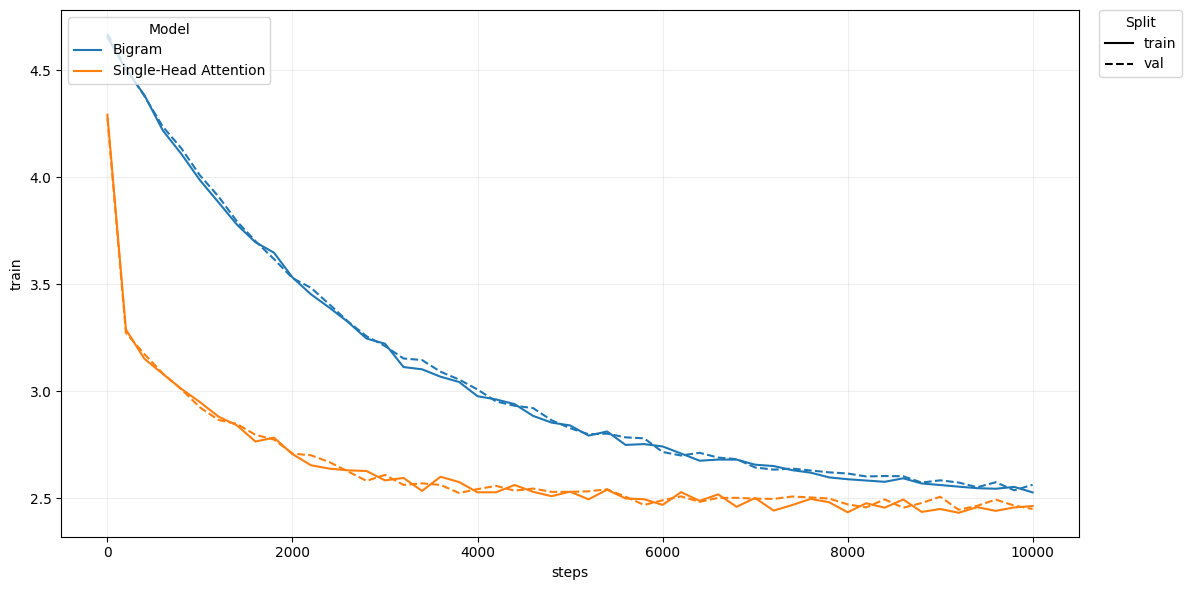

In [19]:
import pandas as pd

losses_df = pd.DataFrame(losses_record)

plot_losses(losses_df)

### Multi-Head Attention Model

This model contains a multi-head attention layer plus a linear layer.

#### Definition

In [20]:
class MultiAttentionHead(nn.Module):

    def __init__(self, n_embedding, n_heads):
        super().__init__()
        head_size = n_embedding//n_heads
        self.heads = nn.ModuleList([AttentionHead(n_embedding=n_embedding, head_size=head_size) for _ in range(n_heads)])
    
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return out
    

class MultiHeadAttentionModel(nn.Module):

    def __init__(self, vocab_size, block_size, n_embedding, n_heads):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embedding)
        self.positional_embedding_table = nn.Embedding(block_size, n_embedding)
        self.multiple_self_attention = MultiAttentionHead(n_embedding=n_embedding, n_heads=n_heads)
        self.linear = nn.Linear(n_embedding, vocab_size)
    
    def forward(self, idx):

        B, T = idx.shape

        token_embeddings = self.token_embedding_table(idx)
        positional_embeddings = self.positional_embedding_table(torch.arange(T))
        embeddings = token_embeddings + positional_embeddings

        attention = self.multiple_self_attention(embeddings)
        out = self.linear(attention)
        return out
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx

xb, yb = get_batch('train')
n_embedding = 32
n_heads = 4
m = MultiHeadAttentionModel(vocab_size=vocab_size, block_size=block_size, n_embedding=n_embedding, n_heads=n_heads)
logits = m(xb)
print(logits.shape)

torch.Size([4, 8, 65])


#### Training

In [21]:
batch_size = 32
n_steps = 10000

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

for steps in range(n_steps): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # predict next token
    logits = m(xb)

    # evaluate the loss
    loss = compute_loss(logits, yb)

    if steps % 200 == 0 or steps == n_steps - 1:
        losses = estimate_loss(model=m)
        print(f"step {steps}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        losses['model'] = 'Multi-Head Attention'
        losses['steps'] = steps
        losses_record.append(losses)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


step 0: train loss 4.2757, val loss 4.2780
step 200: train loss 3.2266, val loss 3.2541
step 400: train loss 3.0729, val loss 3.1249
step 600: train loss 2.9216, val loss 2.9220
step 800: train loss 2.8395, val loss 2.8602
step 1000: train loss 2.7601, val loss 2.7527
step 1200: train loss 2.6891, val loss 2.7442
step 1400: train loss 2.6590, val loss 2.6823
step 1600: train loss 2.6428, val loss 2.6401
step 1800: train loss 2.6175, val loss 2.6125
step 2000: train loss 2.6140, val loss 2.5961
step 2200: train loss 2.5963, val loss 2.5883
step 2400: train loss 2.5428, val loss 2.5607
step 2600: train loss 2.5277, val loss 2.5284
step 2800: train loss 2.5239, val loss 2.5282
step 3000: train loss 2.5209, val loss 2.4991
step 3200: train loss 2.4915, val loss 2.4730
step 3400: train loss 2.4726, val loss 2.5129
step 3600: train loss 2.5046, val loss 2.4789
step 3800: train loss 2.4766, val loss 2.4533
step 4000: train loss 2.4674, val loss 2.4414
step 4200: train loss 2.4501, val loss 2.

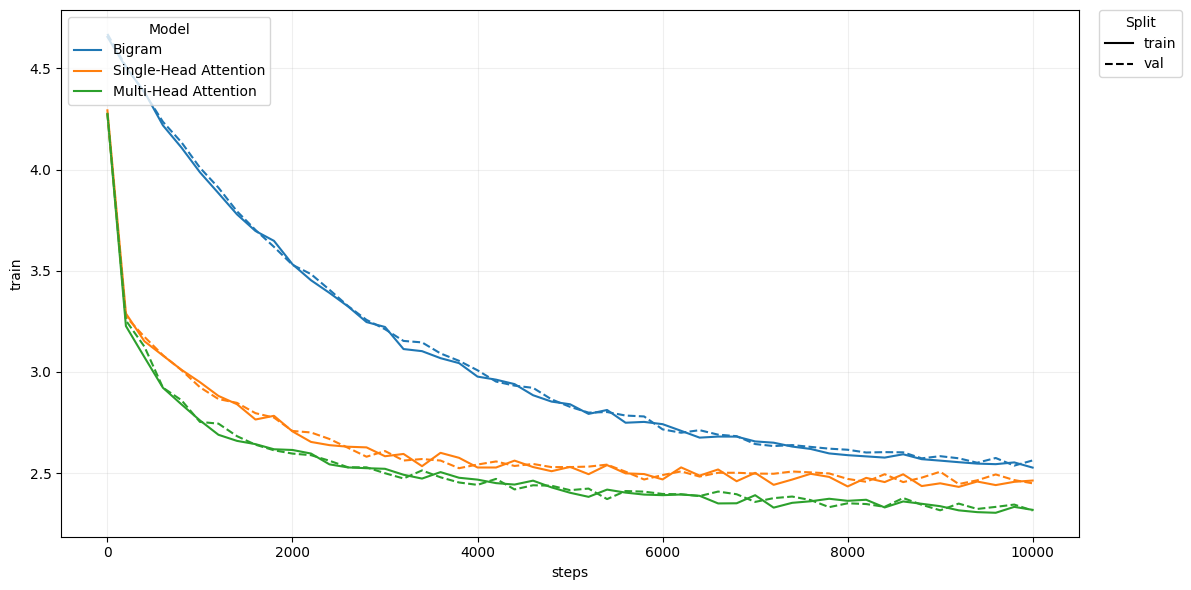

In [22]:
import pandas as pd

losses_df = pd.DataFrame(losses_record)

plot_losses(losses_df)

In [23]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


To as ENRERDald yort tudste rhe dill! athe thatelle ase.

To let vis peance ce of fre sid Tof,
Alent


### Multi-Head + Residual Connection Model

This model contains a multi-head attention layer plus a linear layer. Also:
* a residual connection -> avoid gradient vanishing

#### Definition

In [24]:
class MultiAttentionHead(nn.Module):

    def __init__(self, n_embedding, n_heads):
        super().__init__()
        head_size = n_embedding // n_heads
        self.heads = nn.ModuleList([AttentionHead(n_embedding=n_embedding, head_size=head_size) for _ in range(n_heads)])
        self.proj = nn.Linear(n_embedding, n_embedding)
    
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        return out
    

class FeedForward(nn.Module):

    def __init__(self, n_embedding):
        super().__init__()
        self.net = nn.Sequential(*[
            nn.Linear(n_embedding, n_embedding),
            nn.ReLU(),
            nn.Linear(n_embedding, n_embedding),
        ])

    def forward(self, x):
        out = self.net(x)
        return out


class Block(nn.Module):

    def __init__(self, n_embedding, n_heads):
        super().__init__()
        self.heads = MultiAttentionHead(n_embedding=n_embedding, n_heads=n_heads)
        self.mlp = FeedForward(n_embedding=n_embedding)
    
    def forward(self, x):
        out = self.heads(x) + x
        out = self.mlp(out) + out
        return out

class MultiHeadAttentionResidualConnectionModel(nn.Module):

    def __init__(self, vocab_size, block_size, n_embedding, n_heads):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embedding)
        self.positional_embedding_table = nn.Embedding(block_size, n_embedding)
        self.multiple_self_attention = Block(n_embedding=n_embedding, n_heads=n_heads)
        self.linear = nn.Linear(n_embedding, vocab_size)
    
    def forward(self, idx):

        B, T = idx.shape

        token_embeddings = self.token_embedding_table(idx)
        positional_embeddings = self.positional_embedding_table(torch.arange(T))
        embeddings = token_embeddings + positional_embeddings

        attention = self.multiple_self_attention(embeddings)
        out = self.linear(attention)
        return out
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx

xb, yb = get_batch('train')
n_embedding = 32
n_heads = 4
m = MultiHeadAttentionResidualConnectionModel(vocab_size=vocab_size, block_size=block_size, n_embedding=n_embedding, n_heads=n_heads)
logits = m(xb)
print(logits.shape)

torch.Size([4, 8, 65])


#### Training

In [25]:
batch_size = 32
n_steps = 10000

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

for steps in range(n_steps): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # predict next token
    logits = m(xb)

    # evaluate the loss
    loss = compute_loss(logits, yb)

    if steps % 200 == 0 or steps == n_steps - 1:
        losses = estimate_loss(model=m)
        print(f"step {steps}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        losses['model'] = 'Multi-Head Attention + Residual Connections'
        losses['steps'] = steps
        losses_record.append(losses)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


step 0: train loss 4.4373, val loss 4.4220
step 200: train loss 3.0872, val loss 3.0503
step 400: train loss 2.7847, val loss 2.8679
step 600: train loss 2.7284, val loss 2.7603
step 800: train loss 2.6593, val loss 2.6838
step 1000: train loss 2.5931, val loss 2.5955
step 1200: train loss 2.5460, val loss 2.5840
step 1400: train loss 2.5559, val loss 2.5655
step 1600: train loss 2.5048, val loss 2.5190
step 1800: train loss 2.4586, val loss 2.4983
step 2000: train loss 2.4562, val loss 2.4611
step 2200: train loss 2.4771, val loss 2.4405
step 2400: train loss 2.4235, val loss 2.4332
step 2600: train loss 2.4245, val loss 2.4434
step 2800: train loss 2.4041, val loss 2.4113
step 3000: train loss 2.3726, val loss 2.3954
step 3200: train loss 2.4131, val loss 2.4273
step 3400: train loss 2.3559, val loss 2.3880
step 3600: train loss 2.4141, val loss 2.4008
step 3800: train loss 2.3657, val loss 2.3693
step 4000: train loss 2.3845, val loss 2.3979
step 4200: train loss 2.3446, val loss 2.

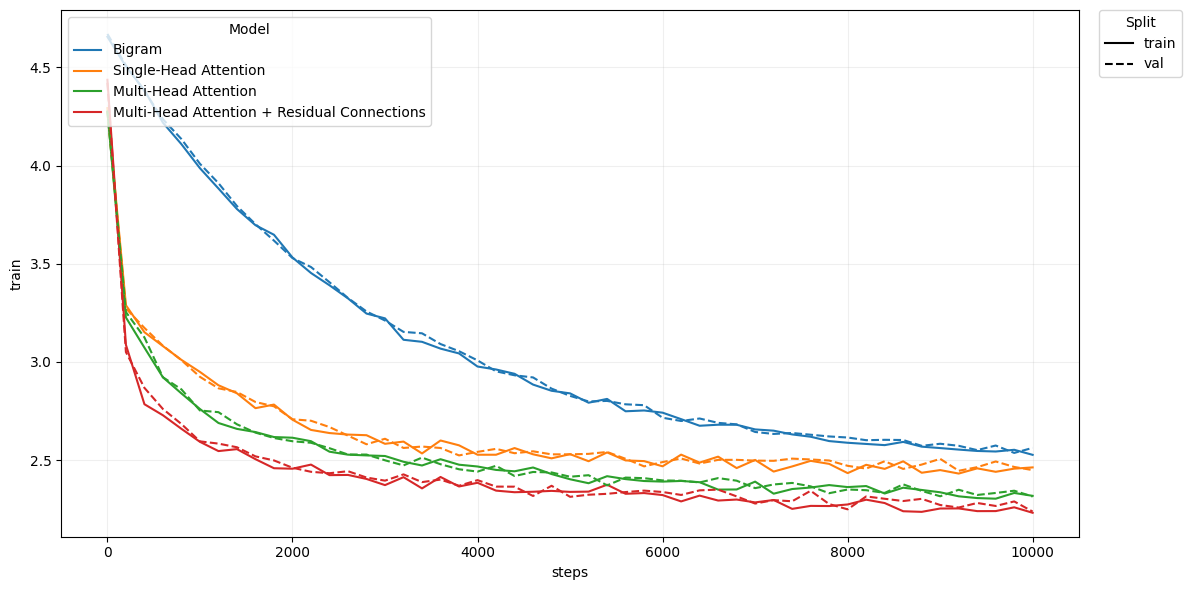

In [26]:
import pandas as pd

losses_df = pd.DataFrame(losses_record)

plot_losses(losses_df)

### Transformer Model

This model contains a multi-head attention layer plus a linear layer. Also:
* a residual connection -> avoid gradient vanishing
* layer normalization

#### Definition

In [27]:
class MultiAttentionHead(nn.Module):

    def __init__(self, n_embedding, n_heads):
        super().__init__()
        head_size = n_embedding // n_heads
        self.heads = nn.ModuleList([AttentionHead(n_embedding=n_embedding, head_size=head_size) for _ in range(n_heads)])
        self.proj = nn.Linear(n_embedding, n_embedding)
        self.layer_norm = nn.LayerNorm(n_embedding)
    
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        out = self.layer_norm(out)
        return out
    

class FeedForward(nn.Module):

    def __init__(self, n_embedding):
        super().__init__()
        self.net = nn.Sequential(*[
            nn.Linear(n_embedding, n_embedding),
            nn.ReLU(),
            nn.Linear(n_embedding, n_embedding),
            nn.LayerNorm(n_embedding)
        ])

    def forward(self, x):
        out = self.net(x)
        return out


class TransformerBlock(nn.Module):

    def __init__(self, n_embedding, n_heads):
        super().__init__()
        self.heads = MultiAttentionHead(n_embedding=n_embedding, n_heads=n_heads)
        self.mlp = FeedForward(n_embedding=n_embedding)
    
    def forward(self, x):
        out = self.heads(x) + x
        out = self.mlp(out) + out
        return out


class TransformerModel(nn.Module):

    def __init__(self, vocab_size, block_size, n_embedding, n_heads):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embedding)
        self.positional_embedding_table = nn.Embedding(block_size, n_embedding)
        self.multiple_self_attention = TransformerBlock(n_embedding=n_embedding, n_heads=n_heads)
        self.linear = nn.Linear(n_embedding, vocab_size)
    
    def forward(self, idx):

        B, T = idx.shape

        token_embeddings = self.token_embedding_table(idx)
        positional_embeddings = self.positional_embedding_table(torch.arange(T))
        embeddings = token_embeddings + positional_embeddings

        attention = self.multiple_self_attention(embeddings)
        out = self.linear(attention)
        return out
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx

xb, yb = get_batch('train')
n_embedding = 32
n_heads = 4
m = TransformerModel(vocab_size=vocab_size, block_size=block_size, n_embedding=n_embedding, n_heads=n_heads)
logits = m(xb)
print(logits.shape)

torch.Size([4, 8, 65])


#### Training

In [28]:
batch_size = 32
n_steps = 10000

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

for steps in range(n_steps): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # predict next token
    logits = m(xb)

    # evaluate the loss
    loss = compute_loss(logits, yb)

    if steps % 200 == 0 or steps == n_steps - 1:
        losses = estimate_loss(model=m)
        print(f"step {steps}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        losses['model'] = 'Transformer'
        losses['steps'] = steps
        losses_record.append(losses)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


step 0: train loss 4.8371, val loss 4.8117
step 200: train loss 2.9966, val loss 3.0562
step 400: train loss 2.8019, val loss 2.8187
step 600: train loss 2.6763, val loss 2.6924
step 800: train loss 2.6302, val loss 2.5964
step 1000: train loss 2.5716, val loss 2.5618
step 1200: train loss 2.5170, val loss 2.4770
step 1400: train loss 2.4929, val loss 2.5068
step 1600: train loss 2.5232, val loss 2.4942
step 1800: train loss 2.4657, val loss 2.4794
step 2000: train loss 2.4208, val loss 2.4572
step 2200: train loss 2.4737, val loss 2.4933
step 2400: train loss 2.4270, val loss 2.4357
step 2600: train loss 2.3678, val loss 2.3826
step 2800: train loss 2.4031, val loss 2.4432
step 3000: train loss 2.3851, val loss 2.3792
step 3200: train loss 2.3563, val loss 2.3989
step 3400: train loss 2.3635, val loss 2.3702
step 3600: train loss 2.3654, val loss 2.3631
step 3800: train loss 2.3631, val loss 2.3474
step 4000: train loss 2.3470, val loss 2.3658
step 4200: train loss 2.3322, val loss 2.

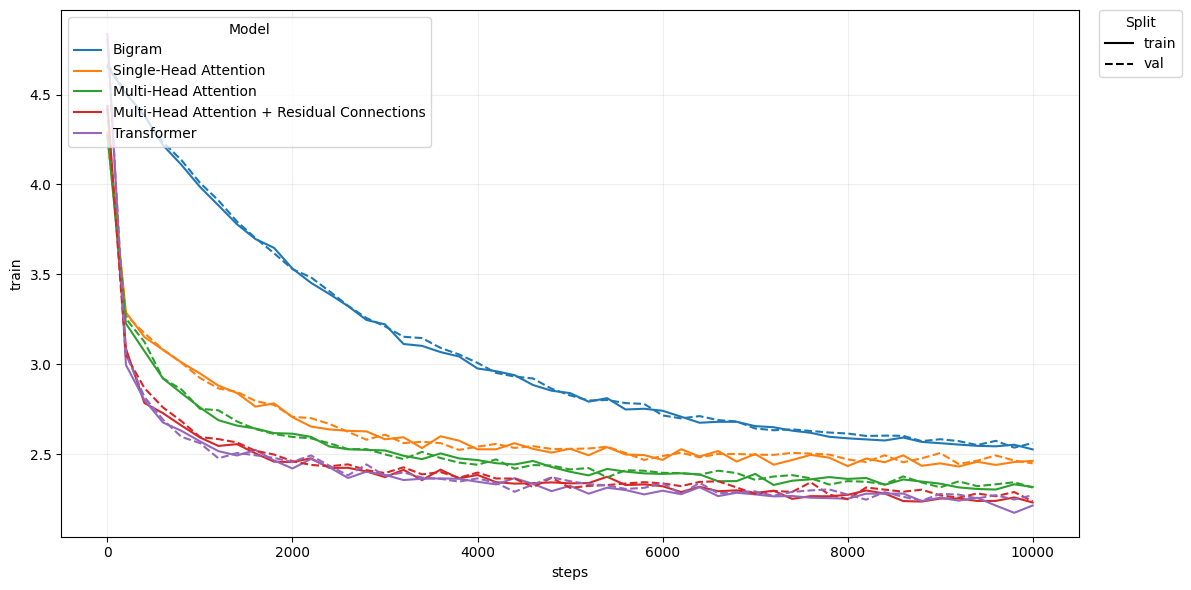

In [29]:
import pandas as pd

losses_df = pd.DataFrame(losses_record)

plot_losses(losses_df)

### GPT Model

This model contains a set of transformer blocks with a final linear layer. No use of drop-out

#### Definition

In [30]:
class MultiAttentionHead(nn.Module):

    def __init__(self, n_embedding, n_heads):
        super().__init__()
        head_size = n_embedding // n_heads
        self.heads = nn.ModuleList([AttentionHead(n_embedding=n_embedding, head_size=head_size) for _ in range(n_heads)])
        self.proj = nn.Linear(n_embedding, n_embedding)
        self.layer_norm = nn.LayerNorm(n_embedding)
    
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        out = self.layer_norm(out)
        return out
    

class FeedForward(nn.Module):

    def __init__(self, n_embedding):
        super().__init__()
        self.net = nn.Sequential(*[
            nn.Linear(n_embedding, n_embedding),
            nn.ReLU(),
            nn.Linear(n_embedding, n_embedding),
            nn.LayerNorm(n_embedding)
        ])

    def forward(self, x):
        out = self.net(x)
        return out


class TransformerBlock(nn.Module):

    def __init__(self, n_embedding, n_heads):
        super().__init__()
        self.heads = MultiAttentionHead(n_embedding=n_embedding, n_heads=n_heads)
        self.mlp = FeedForward(n_embedding=n_embedding)
    
    def forward(self, x):
        out = self.heads(x) + x
        out = self.mlp(out) + out
        return out


class TransformerModel(nn.Module):

    def __init__(self, vocab_size, block_size, n_embedding, n_heads, n_layer):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embedding)
        self.positional_embedding_table = nn.Embedding(block_size, n_embedding)
        self.blocks = nn.Sequential(*[Block(n_embedding, n_heads) for _ in range(n_layer)])
        self.layer_norm = nn.LayerNorm(n_embedding)
        self.linear = nn.Linear(n_embedding, vocab_size)
    
    def forward(self, idx):

        B, T = idx.shape

        token_embeddings = self.token_embedding_table(idx)
        positional_embeddings = self.positional_embedding_table(torch.arange(T))
        embeddings = token_embeddings + positional_embeddings

        attention = self.blocks(embeddings)
        out = self.layer_norm(attention)
        out = self.linear(out)
        return out
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx

xb, yb = get_batch('train')
n_embedding = 32
n_heads = 4
n_layer = 4
m = TransformerModel(vocab_size=vocab_size, block_size=block_size, n_embedding=n_embedding, n_heads=n_heads, n_layer=n_layer)
logits = m(xb)
print(logits.shape)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

torch.Size([4, 8, 65])
0.030017 M parameters


#### Training

In [31]:
batch_size = 32
n_steps = 10000

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

for steps in range(n_steps): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # predict next token
    logits = m(xb)
 
    # evaluate the loss
    loss = compute_loss(logits, yb)

    if steps % 200 == 0 or steps == n_steps - 1:
        losses = estimate_loss(model=m)
        print(f"step {steps}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        losses['model'] = 'GPT'
        losses['steps'] = steps
        losses_record.append(losses)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


step 0: train loss 4.3440, val loss 4.3416
step 200: train loss 3.0477, val loss 3.0508
step 400: train loss 2.8216, val loss 2.8011
step 600: train loss 2.6786, val loss 2.6918
step 800: train loss 2.6052, val loss 2.6073
step 1000: train loss 2.5144, val loss 2.5607
step 1200: train loss 2.5656, val loss 2.5399
step 1400: train loss 2.5202, val loss 2.4928
step 1600: train loss 2.5267, val loss 2.4706
step 1800: train loss 2.4519, val loss 2.4450
step 2000: train loss 2.4017, val loss 2.4432
step 2200: train loss 2.4052, val loss 2.4030
step 2400: train loss 2.4092, val loss 2.4225
step 2600: train loss 2.3939, val loss 2.3844
step 2800: train loss 2.3620, val loss 2.3660
step 3000: train loss 2.3691, val loss 2.3552
step 3200: train loss 2.3115, val loss 2.3627
step 3400: train loss 2.3440, val loss 2.3422
step 3600: train loss 2.3256, val loss 2.3194
step 3800: train loss 2.3154, val loss 2.3095
step 4000: train loss 2.3044, val loss 2.3166
step 4200: train loss 2.2785, val loss 2.

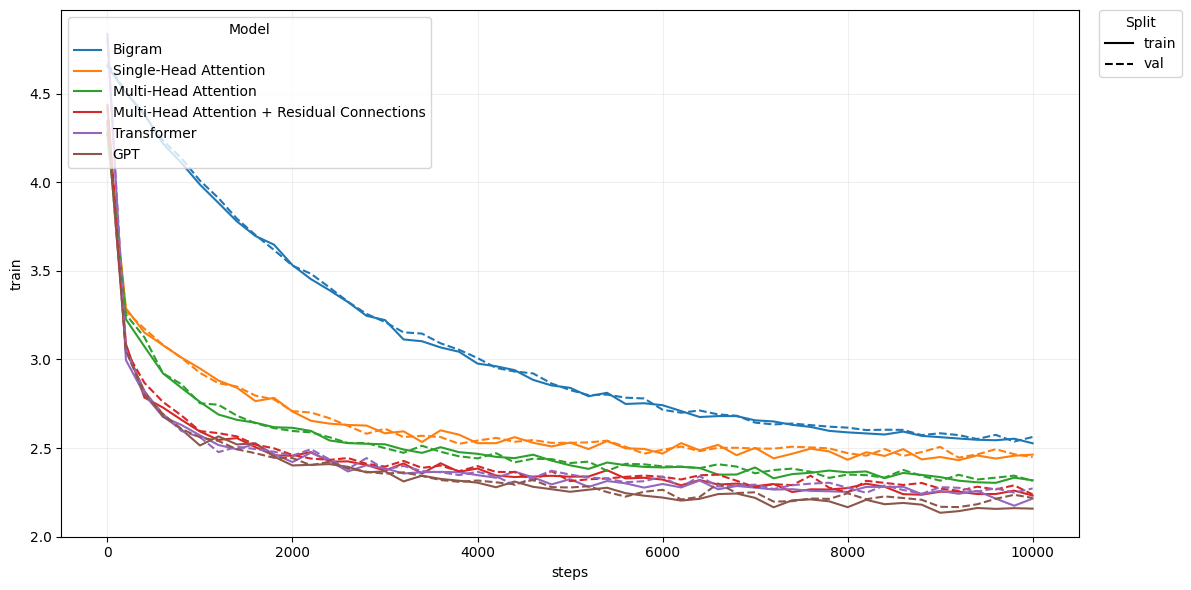

In [32]:
import pandas as pd

losses_df = pd.DataFrame(losses_record)

plot_losses(losses_df)